Prophet: A Forecasting Module from Facebook

The python module fbprophet, also called Prophet, is an open source forecasting software module released by Facebook’s Core Data Science team earlier this year.

The goal of this software is to help users provide reliable, high quality forecasts with a simple, easy to use interface.  How do they do attempt to do this?

They follow the standard scikit-learn model of (a) instantiate an object with configuration parameters, (b) fit a model to the input data and (c) predict the future based upon the past.

Underlying the simple interface, they use a generalized additive regression model of the form:

y(t) = trend(t) + seasonal(t) + holidays(t) + errors(t)

Trend
To make this model more flexible, they allow for change points in the trend (resulting in a piecewise trend).  They allow for both a piecewise linear and piecewise logistic growth model (to be chosen by the user).

Seasonalities
Daily, weekly and yearly seasonalities are automatically handled using a truncated Fourier series.  (By default the yearly seasonality has 10 sine and cosine terms and the weekly seasonality has 3 terms.)  Users can add additional seasonalities by supplying the period and the number of Fourier terms to include.

Holidays
Holidays are handled by assuming their impact is independent, but potentially with an effect extending forward and backward a few days.

In [1]:
import numpy as np
import pandas as pd
from fbprophet import Prophet

import matplotlib.pyplot as plt
import seaborn as sb

import os
import sys #only needed to determine the python version number
import matplotlib #only needed to determine Matplotlib version number

# Enable inline plotting (notebook plotting )
%matplotlib inline
print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

Python version 3.6.3 (v3.6.3:2c5fed8, Oct  3 2017, 18:11:49) [MSC v.1900 64 bit (AMD64)]
Pandas version 0.20.3
Matplotlib version 2.0.2


Miscellaneous Utility Functions

In [2]:
# Static Utility Functions
def csv_set_index(df):
    """Set the unnamed timestamp column as the index for the dataframe.
    :param df: The dataframe to modify
    :return: True when the operation succeeds and False otherwise."""

    if ('Unnamed: 0' in df.columns) and not ('Time' in df.columns):
        df.rename(columns={'Unnamed: 0': 'Time'}, inplace=True)
        df['Time'] = pd.to_datetime(df['Time'])
        df.set_index('Time', inplace=True)
        return True
    return False

def clip_df(df, start=None, end=None):
    if start is None and end is None:
        return df

    # TODO: Prevent/Avoid invalid input
    if start is None:
        d2 = pd.to_datetime(end)
        return df.loc[(df.index < d2), :]

    if end is None:
        d1 = pd.to_datetime(start)
        return df.loc[(d1 <= df.index), :]

    d1 = pd.to_datetime(start)
    d2 = pd.to_datetime(end)
    indexer = ((d1 <= df.index) & (df.index < d2))
    return df.loc[indexer, :]

def shift_day(today, shift):
    """Shift today by the given number of days."""

    target_day = ''
    # Python 3+ specific code: isinstance(today, str)
    if today and isinstance(today, str):
        try:
            target_day = (pd.to_datetime(today) + pd.DateOffset(days=shift)).strftime('%Y-%m-%d')
        except (TypeError, ValueError):
            # logger.error("Invalid date format encounted.  Try putting the date in this form, '%Y-%m-%d'.")
            pass

    return target_day

Residual Calculation

A function to calculate the difference between the actual data (df_data) and the forecast (df_base).

In [3]:
def calculate_residual_dataframe(df_data, df_base):
    """A function to calculate the Prophet Forecast Errors = Data - Forecast
    :param df_data: DataFrame with Integer indices, and columns ds and y
    :param df_base: DataFrame with datetime indices, and column yhat
    :return: DataFrame with datetime indices, and column residual = y - yhat"""

    print("Entered calculate_residual_dataframe")
    if df_data is None or df_base is None:
        print("Input None?")
        # logger.error("A dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_data, pd.DataFrame):
        print("df_data: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if not isinstance(df_base, pd.DataFrame):
        print("df_base: Not a dataframe?")
        # logger.error("The dataframe input to calculate_residual_dataframe is invalid")
        return None

    if df_data.empty or df_base.empty:
        print("Empty dataframe?")
        # logger.error("Empty dataframe passed into calculate_residual_dataframe")
        return None

    # Prophet requires the datetime column to be named 'ds'.
    if not 'ds' in df_data.columns.values:
        print("ds no in df_data?")
        # logger.warn("Expected column ds in the data.  Skipping residual calculation.")
        return None
    
    # Prophet requires the data column to be named 'y'.
    if not 'y' in df_data.columns.values:
        print("y not in df_data?")
        # logger.warn("Expected column y in the data.  Skipping residual calculation.")
        return None

    # Prophet names the predicted data column 'yhat'.
    if not 'yhat' in df_base.columns.values:
        print("yhat not in df_base?")
        # logger.warn("Expected column yhat in the prediction.  Skipping residual calculation.")
        return None

    df = df_data.set_index('ds')
    y = df.loc[df.index.isin(df_base.index), 'y']
    yhat = df_base.loc[df_base.index.isin(df.index), 'yhat']
    residual = y.subtract(yhat, fill_value=0)

    return residual.to_frame().rename(columns={0:'Residual'})

Read In The Data, Adjust The Time Zone

Read in the csv file with the throughput data for a specific link on a network.  The data is collected in the Pacific time zone, but captured without time zone information (and therefore is handled as UTC data).

The handling of holidays by Prophet works best when the start and end of the impact of a holiday are confined to the specified days.  Therefore, we want to adjust the time zone of the collected data to match the day boundaries that will be used by Prophet.

Therefore we will adjust the timestamps to the correct timezone.  After making this adjustment, we remove the timezone information to simplify future processing.

In [4]:
data_file = "C:/Prophet/data_sets/per15minute_data_AP1_Incoming.csv"
df = pd.read_csv(data_file)

In [5]:
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15930 entries, 0 to 15929
Data columns (total 25 columns):
Unnamed: 0                     15930 non-null object
avg_hrcrx_max_byt              15930 non-null float64
count_hrcrx_max_byt            15930 non-null int64
max_hrcrx_max_byt              15930 non-null int64
max_hrcrx_std_byt              11615 non-null float64
min_hrcrx_max_byt              15930 non-null int64
min_hrcrx_std_byt              11615 non-null float64
percentile_10_hrcrx_max_byt    15930 non-null int64
percentile_20_hrcrx_max_byt    15930 non-null int64
percentile_25_hrcrx_max_byt    11615 non-null float64
percentile_25_hrcrx_std_byt    11615 non-null float64
percentile_30_hrcrx_max_byt    15930 non-null int64
percentile_40_hrcrx_max_byt    11615 non-null float64
percentile_50_hrcrx_max_byt    15930 non-null int64
percentile_50_hrcrx_std_byt    11615 non-null float64
percentile_60_hrcrx_max_byt    11615 non-null float64
percentile_70_hrcrx_max_byt    15930 non-n

In [6]:
df.head()

,Unnamed: 0,avg_hrcrx_max_byt,count_hrcrx_max_byt,max_hrcrx_max_byt,max_hrcrx_std_byt,min_hrcrx_max_byt,min_hrcrx_std_byt,percentile_10_hrcrx_max_byt,percentile_20_hrcrx_max_byt,percentile_25_hrcrx_max_byt,...,percentile_60_hrcrx_max_byt,percentile_70_hrcrx_max_byt,percentile_75_hrcrx_max_byt,percentile_75_hrcrx_std_byt,percentile_80_hrcrx_max_byt,percentile_85_hrcrx_max_byt,percentile_90_hrcrx_max_byt,percentile_95_hrcrx_max_byt,percentile_98_hrcrx_max_byt,std_hrcrx_max_byt
0,2017-03-18 00:00:00+00:00,1169.807923,833,23840,NaN,64,NaN,77,128,NaN,...,NaN,414,NaN,NaN,496,NaN,4376,NaN,NaN,NaN
1,2017-03-18 00:15:00+00:00,875.379001,781,12384,NaN,64,NaN,64,121,NaN,...,NaN,414,NaN,NaN,474,NaN,767,NaN,NaN,NaN
2,2017-03-18 00:30:00+00:00,894.969925,798,15180,NaN,64,NaN,64,121,NaN,...,NaN,414,NaN,NaN,474,NaN,1045,NaN,NaN,NaN
3,2017-03-18 00:45:00+00:00,862.053232,789,8859,NaN,64,NaN,64,64,NaN,...,NaN,414,NaN,NaN,474,NaN,767,NaN,NaN,NaN
4,2017-03-18 01:00:00+00:00,956.235079,821,28272,NaN,64,NaN,64,70,NaN,...,NaN,414,NaN,NaN,474,NaN,1310,NaN,NaN,NaN


In [7]:
df.tail()

,Unnamed: 0,avg_hrcrx_max_byt,count_hrcrx_max_byt,max_hrcrx_max_byt,max_hrcrx_std_byt,min_hrcrx_max_byt,min_hrcrx_std_byt,percentile_10_hrcrx_max_byt,percentile_20_hrcrx_max_byt,percentile_25_hrcrx_max_byt,...,percentile_60_hrcrx_max_byt,percentile_70_hrcrx_max_byt,percentile_75_hrcrx_max_byt,percentile_75_hrcrx_std_byt,percentile_80_hrcrx_max_byt,percentile_85_hrcrx_max_byt,percentile_90_hrcrx_max_byt,percentile_95_hrcrx_max_byt,percentile_98_hrcrx_max_byt,std_hrcrx_max_byt
15925,2017-08-30 22:45:00+00:00,11677.503330,900,38036,12738.552570,201,19.037620,2658,2682,2706.0,...,14046.0,15180,15180.0,770.324960,16597,21002.0,30360,33262.0,33396.0,9716.992504
15926,2017-08-30 23:00:00+00:00,12531.888890,900,76890,10682.084860,309,11.853313,1120,2617,2682.0,...,13662.0,15180,18216.0,1184.261865,27324,30828.0,32091,33396.0,33764.0,12023.864220
15927,2017-08-30 23:15:00+00:00,9899.652948,899,35232,9915.013821,64,2.022846,340,602,770.0,...,9108.0,15180,15180.0,701.985377,16698,26006.0,31813,32708.0,33396.0,11102.138860
15928,2017-08-30 23:30:00+00:00,2714.915919,892,33396,2835.673945,64,2.022846,159,201,220.0,...,754.0,1312,1588.0,83.891655,3518,4739.0,8106,11904.0,25806.0,5580.909083
15929,2017-08-30 23:45:00+00:00,2804.447277,863,33764,6373.245739,64,2.022846,128,180,205.0,...,591.0,1090,1424.0,64.232116,3705,6227.0,8947,14350.0,26900.0,5866.768082


Use the times in the "Unnamed: 0" column as the index for the dataframe by calling the "csv_set_index" function defined earlier in this notebook.

In [8]:
csv_set_index(df)

True

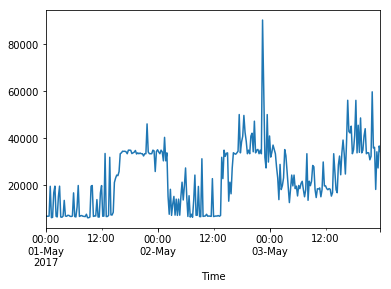

In [9]:
df.loc['2017-05-01':'2017-05-03', 'max_hrcrx_max_byt'].plot()

Notice that the activity does not correspond to the expected time intervals.  The activity picks up a bit after noon and slows down after midnight.  These are 'UTC' time samples in the 'Pacific' time zone.  To correctly handle holidays, we should shift the data to the Pacific time zone.  (Because we do not need to worry about daylight savings, we could either shift the index or we could localize the time stamps.  We will localize the time stamps.)

In [10]:
df = df.tz_localize('UTC').tz_convert('US/Pacific')
df = df.tz_localize(None)

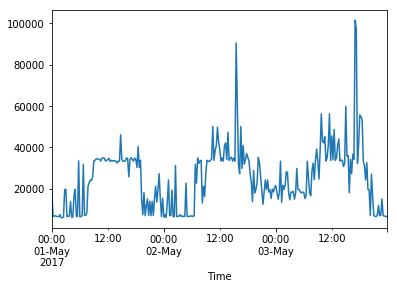

In [11]:
df.loc['2017-05-01':'2017-05-03', 'max_hrcrx_max_byt'].plot()

In [12]:
df.tail()

,avg_hrcrx_max_byt,count_hrcrx_max_byt,max_hrcrx_max_byt,max_hrcrx_std_byt,min_hrcrx_max_byt,min_hrcrx_std_byt,percentile_10_hrcrx_max_byt,percentile_20_hrcrx_max_byt,percentile_25_hrcrx_max_byt,percentile_25_hrcrx_std_byt,...,percentile_60_hrcrx_max_byt,percentile_70_hrcrx_max_byt,percentile_75_hrcrx_max_byt,percentile_75_hrcrx_std_byt,percentile_80_hrcrx_max_byt,percentile_85_hrcrx_max_byt,percentile_90_hrcrx_max_byt,percentile_95_hrcrx_max_byt,percentile_98_hrcrx_max_byt,std_hrcrx_max_byt
Time,,,,,,,,,,,,,,,,,,,,,
2017-08-30 15:45:00,11677.503330,900,38036,12738.552570,201,19.037620,2658,2682,2706.0,128.197829,...,14046.0,15180,15180.0,770.324960,16597,21002.0,30360,33262.0,33396.0,9716.992504
2017-08-30 16:00:00,12531.888890,900,76890,10682.084860,309,11.853313,1120,2617,2682.0,90.689991,...,13662.0,15180,18216.0,1184.261865,27324,30828.0,32091,33396.0,33764.0,12023.864220
2017-08-30 16:15:00,9899.652948,899,35232,9915.013821,64,2.022846,340,602,770.0,37.497969,...,9108.0,15180,15180.0,701.985377,16698,26006.0,31813,32708.0,33396.0,11102.138860
2017-08-30 16:30:00,2714.915919,892,33396,2835.673945,64,2.022846,159,201,220.0,11.358618,...,754.0,1312,1588.0,83.891655,3518,4739.0,8106,11904.0,25806.0,5580.909083
2017-08-30 16:45:00,2804.447277,863,33764,6373.245739,64,2.022846,128,180,205.0,8.912514,...,591.0,1090,1424.0,64.232116,3705,6227.0,8947,14350.0,26900.0,5866.768082


Restrict The Dates

The data collected in this data set changed during the first of May.  To avoid dealing with this change, we will drop all of the data collected prior to the second of May.

Time
2017-05-02 00:00:00     6365
2017-05-02 00:15:00     7580
2017-05-02 00:30:00     6286
2017-05-02 00:45:00    13662
2017-05-02 01:00:00    24288
Name: max_hrcrx_max_byt, dtype: int64
Time
2017-08-29 22:45:00     7069
2017-08-29 23:00:00     6811
2017-08-29 23:15:00     7184
2017-08-29 23:30:00    20590
2017-08-29 23:45:00     6924
Name: max_hrcrx_max_byt, dtype: int64


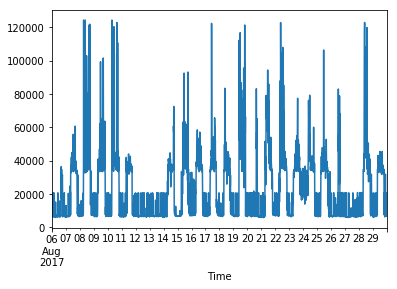

In [13]:
d1 = pd.to_datetime('2017-05-02')
d2 = pd.to_datetime('2017-08-30')

y_indexer = ((d1 <= df.index) & (df.index < d2))
y_values = df.loc[y_indexer,'max_hrcrx_max_byt']
print(y_values.head())
print(y_values.tail())
y_values['2017-08-06':'2017-08-30'].plot()

Prepare the dataframe for use by the Prophet class

In [14]:
num_rows = len(y_values.index)
c1 = y_values.index
c2 = y_values.values
col_data = np.array([c1, c2]).T
col_names = ['ds', 'y']
df_data = pd.DataFrame(index=range(num_rows), data=col_data, columns=col_names)

In [15]:
folder_name = "C:/Prophet/data_sets"
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

prophet_data_file_name = "modified_per15minute_data_AP1_Incoming.csv"
data_file_name = "{}/{}".format(folder_name, prophet_data_file_name)
if not os.path.exists(data_file_name):
    df_data.to_csv("{}".format(data_file_name))

View The Data

Plot the data to get a feel for what type of model is appropriate.  Prophet uses a Generalized Additive Model with a piecewise linear trend and multiple seasonalities.

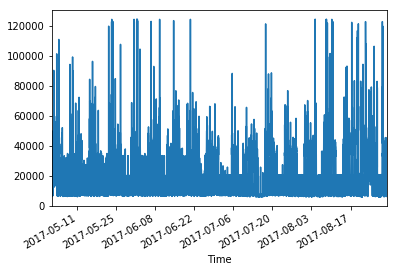

In [16]:
y_values.plot()

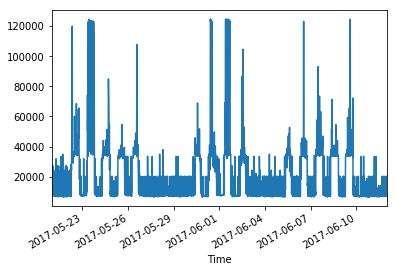

In [17]:
# y_values.loc['2017-05-02':'2017-05-21'].plot()
y_values.loc['2017-05-21':'2017-06-11'].plot()
# y_values.loc['2017-06-11':'2017-07-02'].plot()
# y_values.loc['2017-07-02':'2017-07-23'].plot()
# y_values.loc['2017-07-23':'2017-08-13'].plot()
# y_values.loc['2017-08-13':'2017-09-03'].plot()

Memorial Day

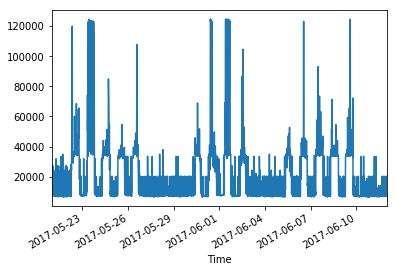

In [18]:
y_values.loc['2017-05-21':'2017-06-11'].plot()

4th of July

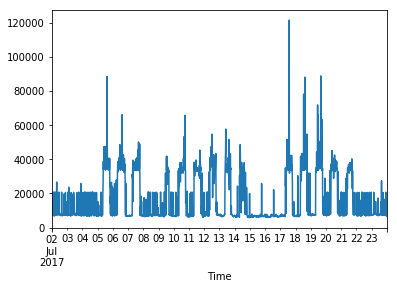

In [19]:
y_values.loc['2017-07-02':'2017-07-23'].plot()

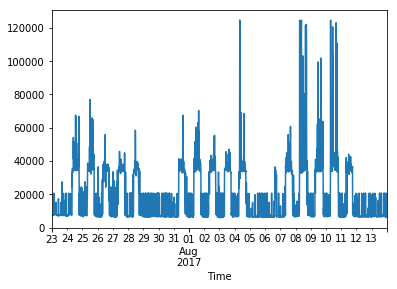

In [20]:
y_values.loc['2017-07-23':'2017-08-13'].plot()

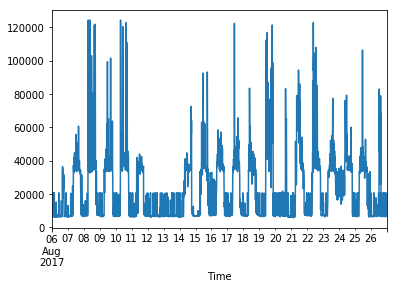

In [21]:
y_values.loc['2017-08-06':'2017-08-26'].plot()

Now we are ready to move to forecasting the data using the fbprophet module.  But first, we take a quick diversion to introduce the Prophet class.

Prophet

Prophet provides functionality for forecasting time series data.  It is based on a general additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays.  Prophet was written to process daily periodicity data with at least one year of historical data, however, the code has recently been updated to handle non-daily data.  The creators of Prophet claim it is "robust to missing data, shifts in the trend, and large outliers".

Prophet is open source software released by Facebook's Core Data Science team. It is available for download on PyPI.

Input

The input to the Prophet fit function is a dataframe with two data columns named 'ds' and 'y'. The data type in the ds (datestamp) column must be date or datetime. The y column must be numeric, and represents the measurement we wish to forecast.

In all examples I have seen, the dataframe index is a list of integers.

Usage

Prophet follows the sklearn model API.  First create an instance of the Prophet class and then call its fit and predict methods.

Help

To see functions defined for the Prophet class, type "Prophet.<TAB>"
To get help on the function foo, type "help(Prophet.foo)" or "?Prophet.foo"


In [ ]:
# Prophet.

In [43]:
# help(Prophet.fit)

Help on function fit in module fbprophet.forecaster:

fit(self, df, **kwargs)
    Fit the Prophet model.
    
    This sets self.params to contain the fitted model parameters. It is a
    dictionary parameter names as keys and the following items:
        k (Mx1 array): M posterior samples of the initial slope.
        m (Mx1 array): The initial intercept.
        delta (MxN array): The slope change at each of N changepoints.
        beta (MxK matrix): Coefficients for K seasonality features.
        sigma_obs (Mx1 array): Noise level.
    Note that M=1 if MAP estimation.
    
    Parameters
    ----------
    df: pd.DataFrame containing the history. Must have columns ds (date
        type) and y, the time series. If self.growth is 'logistic', then
        df must also have a column cap that specifies the capacity at
        each ds.
    kwargs: Additional arguments passed to the optimizing or sampling
        functions in Stan.
    
    Returns
    -------
    The fitted Prophet objec

In [44]:
# ?Prophet.make_future_dataframe

# help(Prophet.predict)

In [23]:
# m1 = Prophet()
m1 = Prophet(yearly_seasonality=False)

In [24]:
m1.fit(df_data)

Prophet provides a convenience function, "make_future_dataframe", to create a dataframe that may be passed into the "predict" function.

In [25]:
df_future1 = m1.make_future_dataframe(periods=7*24*4, freq='15T')
df_future2 = m1.make_future_dataframe(periods=2*7*24*4, freq='15T')
df_future4 = m1.make_future_dataframe(periods=4*7*24*4, freq='15T')
print(df_future2.head())
print(df_future2.tail())

                   ds
0 2017-05-02 00:00:00
1 2017-05-02 00:15:00
2 2017-05-02 00:30:00
3 2017-05-02 00:45:00
4 2017-05-02 01:00:00
                       ds
12858 2017-09-12 22:45:00
12859 2017-09-12 23:00:00
12860 2017-09-12 23:15:00
12861 2017-09-12 23:30:00
12862 2017-09-12 23:45:00


In [26]:
df_forecast2 = m1.predict(df_future2)
df_forecast2.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,daily,daily_lower,daily_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yhat
12858,2017-09-12 22:45:00,28084.626356,26293.259737,30007.783066,5711.957573,36821.989558,-10360.262606,-10360.262606,-10360.262606,-6173.761073,-6173.761073,-6173.761073,-6173.761073,-6173.761073,-6173.761073,4186.501533,4186.501533,4186.501533,21910.865284
12859,2017-09-12 23:00:00,28086.647012,26291.606352,30011.688458,6004.834925,37921.357786,-10351.059566,-10351.059566,-10351.059566,-6158.025728,-6158.025728,-6158.025728,-6158.025728,-6158.025728,-6158.025728,4193.033838,4193.033838,4193.033838,21928.621283
12860,2017-09-12 23:15:00,28088.667667,26289.952968,30015.593851,6318.122703,38117.238956,-10324.274874,-10324.274874,-10324.274874,-6124.292864,-6124.292864,-6124.292864,-6124.292864,-6124.292864,-6124.292864,4199.982011,4199.982011,4199.982011,21964.374804
12861,2017-09-12 23:30:00,28090.688323,26288.299583,30019.499244,5281.883324,37947.535338,-10285.266860,-10285.266860,-10285.266860,-6077.925256,-6077.925256,-6077.925256,-6077.925256,-6077.925256,-6077.925256,4207.341604,4207.341604,4207.341604,22012.763067
12862,2017-09-12 23:45:00,28092.708978,26286.646198,30023.404637,5753.793374,38579.956788,-10237.885183,-10237.885183,-10237.885183,-6022.777474,-6022.777474,-6022.777474,-6022.777474,-6022.777474,-6022.777474,4215.107709,4215.107709,4215.107709,22069.931504


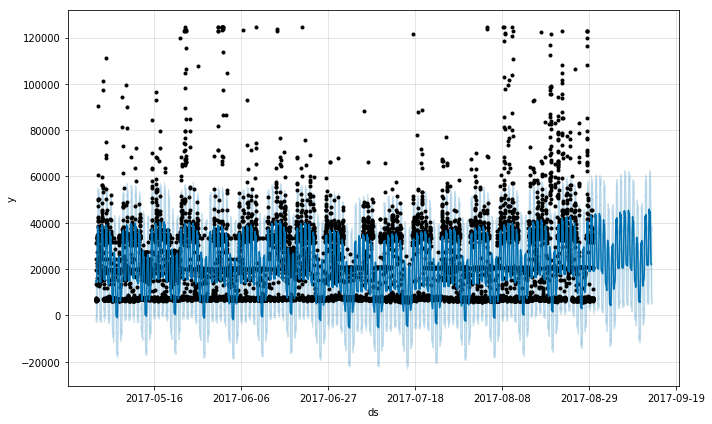

In [27]:
m1.plot(df_forecast2);

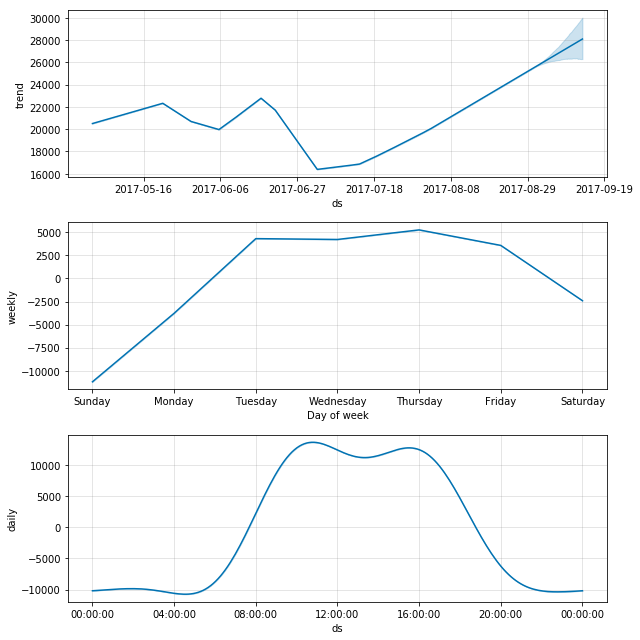

In [28]:
m1.plot_components(df_forecast2);

Forecast Region

To get a better picture of the forecast, let's restrict the plot to the final two weeks of data, along with the week of forecast behavior.

In [29]:
d1 = shift_day('2017-08-30', -14)
# Use d2 = '2017-08-29' when end date is included in the range
# Use d2 = '2017-08-30' when the end date will be excluded from the range
# (as happens when calling "clip_df")
d2 = '2017-08-29'
d3 = shift_day(d2, 14)
# d4 = shift_day(d2, 28)
yhat = df_forecast2.set_index('ds').loc[d1:d3, 'yhat']

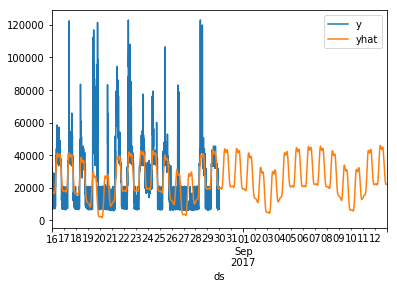

In [30]:
y = pd.Series(index=yhat.index)
y = y_values[d1:d3]

df_predictions = pd.DataFrame(index=yhat.index)
df_predictions['y'] = y[d1:d2]
df_predictions['yhat'] = yhat
df_predictions.plot()

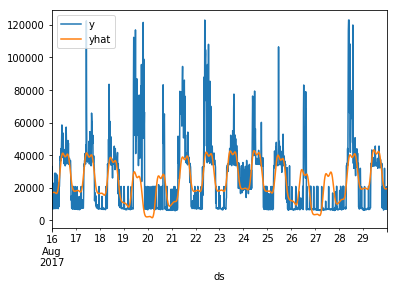

In [31]:
df_predictions.loc[d1:d2, ['y', 'yhat']].plot()

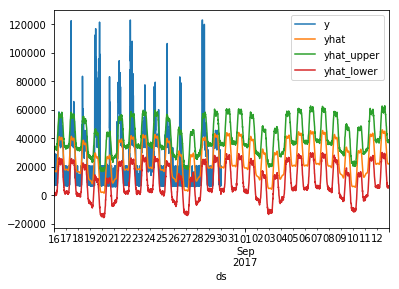

In [32]:
df_predictions['yhat_upper'] = df_forecast2.set_index('ds').loc[d1:d3, 'yhat_upper']
df_predictions['yhat_lower'] = df_forecast2.set_index('ds').loc[d1:d3, 'yhat_lower']
df_predictions.loc[d1:d3].plot()

In Sample Residual


Entered calculate_residual_dataframe


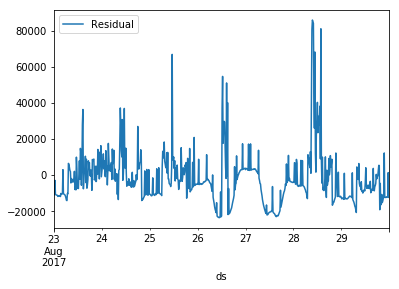

In [33]:
df_prophet_residual = calculate_residual_dataframe(df_data, df_forecast2.set_index('ds'))

predicted_data_start = pd.to_datetime('2017-08-23')
predicted_data_end = pd.to_datetime('2017-08-30')
clip_df(df_prophet_residual, '2017-08-23', '2017-08-30').plot()

In [34]:
def rms_error(residuals):
    return np.sqrt(np.mean(residuals**2))

def mean_abs_error(residuals):
    return np.mean(np.abs(residuals))

prophet_residuals = df_prophet_residual.loc['2017-08-23':'2017-08-29', 'Residual'].get_values()
prophet_rmse = rms_error(prophet_residuals)
prophet_mae = mean_abs_error(prophet_residuals)

In [35]:
print("Prophet MAE = {}".format(prophet_mae))

Prophet MAE = 10134.033591659125


In [36]:
print("Prophet RMSE = {}".format(prophet_rmse))

Prophet RMSE = 14521.626911200927


Out of Sample Residuals and Cross Validation


In [37]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m1, horizon='14 days', period='7 days')

In [38]:
print(df_cv.head())
print(df_cv.tail())

                   ds          yhat   yhat_lower    yhat_upper      y  \
0 2017-06-14 00:00:00  15638.106088 -1342.295871  31742.774017   6819   
1 2017-06-14 00:15:00  15754.694086   -21.331420  32562.617664   7050   
2 2017-06-14 00:30:00  15854.569687 -1560.062678  32303.338025   6938   
3 2017-06-14 00:45:00  15933.541606  -817.645682  30954.811768   6731   
4 2017-06-14 01:00:00  15988.421776  -566.733656  31687.508274  20190   

               cutoff  
0 2017-06-13 23:45:00  
1 2017-06-13 23:45:00  
2 2017-06-13 23:45:00  
3 2017-06-13 23:45:00  
4 2017-06-13 23:45:00  
                       ds          yhat   yhat_lower    yhat_upper      y  \
13435 2017-08-29 22:45:00  18514.130255  3586.284363  33687.273495   7069   
13436 2017-08-29 23:00:00  18549.381798  3442.752087  33975.793558   6811   
13437 2017-08-29 23:15:00  18594.140088  2993.451018  32882.150654   7184   
13438 2017-08-29 23:30:00  18643.468438  3368.338231  34251.910996  20590   
13439 2017-08-29 23:45:00  18694

In [39]:
df_cv['Residuals'] = df_cv['y'] - df_cv['yhat']
last_index = df_cv.index[-1]
start_index = (last_index + 1) - 2*7*24*4
print(df_cv.iloc[start_index:last_index,:].head())
print(df_cv.iloc[start_index:last_index,:].tail())

                       ds          yhat   yhat_lower    yhat_upper      y  \
12096 2017-08-16 00:00:00  16909.605078  2822.162714  32636.169230   6957   
12097 2017-08-16 00:15:00  16958.113056  1206.403093  33134.931005  33022   
12098 2017-08-16 00:30:00  17004.219046  1073.176520  30591.054464   7065   
12099 2017-08-16 00:45:00  17047.060419  1825.295221  32401.400484  21252   
12100 2017-08-16 01:00:00  17085.350913  2046.277257  32279.434507   7888   

                   cutoff     Residuals  
12096 2017-08-15 23:45:00  -9952.605078  
12097 2017-08-15 23:45:00  16063.886944  
12098 2017-08-15 23:45:00  -9939.219046  
12099 2017-08-15 23:45:00   4204.939581  
12100 2017-08-15 23:45:00  -9197.350913  
                       ds          yhat   yhat_lower    yhat_upper      y  \
13434 2017-08-29 22:30:00  18495.370426  3295.026000  33231.215285   6809   
13435 2017-08-29 22:45:00  18514.130255  3586.284363  33687.273495   7069   
13436 2017-08-29 23:00:00  18549.381798  3442.752087  

In [40]:
s1 = (last_index + 1) - 7*24*4
residuals = df_cv['Residuals'].get_values()
print("Full RMSE = {}".format(rms_error(residuals)))
print("2 Week RMSE = {}".format(rms_error(residuals[start_index:])))
print("1 Week RMSE = {}".format(rms_error(residuals[s1:])))

Full RMSE = 13996.645516789698
2 Week RMSE = 17829.622373189766
1 Week RMSE = 14566.589554741598


In [42]:
print("Full MAE = {}".format(mean_abs_error(residuals)))
print("Tail MAE = {}".format(mean_abs_error(residuals[start_index:])))
print("1 Week MAE = {}".format(mean_abs_error(residuals[s1:])))

Full MAE = 9878.234168070665
Tail MAE = 11299.874786469629
1 Week MAE = 9762.426429279016
